In [20]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, ConfusionMatrixDisplay,confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [21]:
df = pd.read_csv("predict_students_dropout_and_academic_success.csv",delimiter=";")
le = LabelEncoder()
df["Target"] = le.fit_transform(df["Target"])

[I 2025-05-15 17:45:07,661] A new study created in memory with name: no-name-afb9f921-f3cb-42eb-b1a2-5463df8b3531
[I 2025-05-15 17:45:13,636] Trial 0 finished with values: [0.9872845395919738, 5.9736127853393555] and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': 'sqrt'}.
[I 2025-05-15 17:45:19,736] Trial 1 finished with values: [0.9968910571444554, 6.0980002880096436] and parameters: {'n_estimators': 435, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}.
[I 2025-05-15 17:45:21,668] Trial 2 finished with values: [0.996326484948737, 1.930110216140747] and parameters: {'n_estimators': 133, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt'}.
[I 2025-05-15 17:45:25,394] Trial 3 finished with values: [0.9861541965334549, 3.724170684814453] and parameters: {'n_estimators': 283, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_fe


Best Hyperparameters: FrozenTrial(number=29, state=1, values=[1.0, 1.3810222148895264], datetime_start=datetime.datetime(2025, 5, 15, 17, 46, 51, 230824), datetime_complete=datetime.datetime(2025, 5, 15, 17, 46, 52, 612674), params={'n_estimators': 86, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}, user_attrs={}, system_attrs={'NSGAIISampler:generation': 0}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=450, log=False, low=10, step=1), 'max_depth': IntDistribution(high=50, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=29, value=None)


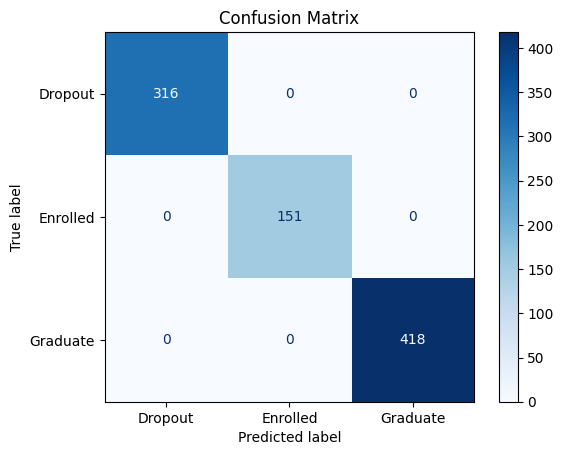


Classification Report (per-class precision, recall, F1):
              precision    recall  f1-score   support

     Dropout     1.0000    1.0000    1.0000       316
    Enrolled     1.0000    1.0000    1.0000       151
    Graduate     1.0000    1.0000    1.0000       418

    accuracy                         1.0000       885
   macro avg     1.0000    1.0000    1.0000       885
weighted avg     1.0000    1.0000    1.0000       885



In [22]:
# Assume df has features and df_encoded["Target"] is the encoded label
X = df
y = df["Target"]

# Optional: split to test performance later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Optuna objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 450),
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    clf = RandomForestClassifier(**params, random_state=42)
    # Cross-validate on training data
    start = time.time()
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()
    duration = time.time() - start
    return score, duration

# Run the Optuna study
study = optuna.create_study(directions=["maximize","minimize"])
study.optimize(objective, n_trials=50)

# Print best parameters
best_trial = sorted(study.trials, key=lambda t: (-t.values[0], t.values[1]))[0]
print("\nBest Hyperparameters:", best_trial)

# Train final model on best parameters
best_clf = RandomForestClassifier(**best_trial.params, random_state=42)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X=X_test)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform(best_clf.classes_))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Per-class precision, recall, F1-score

print("\nClassification Report (per-class precision, recall, F1):")
# Inverse transform encoded labels back to original
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Generate report using original class labels
print(classification_report(y_test_labels, y_pred_labels, digits=4))